### Setup of a two-qubit chip with $C^3$

In this example we will set-up a two qubit quantum processor and define a simple gate.

#### Imports

In [2]:
!pip install -q -U pip
!pip install -q matplotlib

In [14]:
# System imports
import copy
import numpy as np
import time
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from pprint import pprint

# Main C3 objects
from c3.c3objs import Quantity as Qty
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.model import Model as Mdl
from c3.generator.generator import Generator as Gnr

# Building blocks
from c3.generator import devices
from c3.signal import gates
from c3.libraries import chip
from c3.signal import pulse
from c3.libraries import tasks

# Libs and helpers
from c3.libraries import algorithms
from c3.libraries import hamiltonians
from c3.libraries import fidelities
from c3.libraries import envelopes
from c3.utils import qt_utils
from c3.utils import tf_utils

#### Model components
We first create a qubit. Each parameter is a Quantity (`Qty()`) object with bounds and a unit. In $C^3$, the default multi-level qubit is a Transmon modelled as a Duffing oscillator with frequency $\omega$ and anharmonicity $\delta$ :
$$ H/\hbar = \omega b^\dagger b - \frac{\delta}{2}                        \left(b^\dagger b - 1\right) b^\dagger b 
$$
The "name" will be used to identify this qubit (or other component) later and should thus be chosen carefully.

In [15]:
qubit_lvls = 3
freq_q1 = 5e9
anhar_q1 = -110e6
t1_q1 = 27e-6
t2star_q1 = 39e-6
qubit_temp = 50e-3

q1 = chip.Qubit(
    name="Q1",
    desc="Qubit 1",
    freq=Qty(
        value=freq_q1,
        min_val=4.995e9 ,
        max_val=5.005e9 ,
        unit='Hz 2pi'
    ),
    anhar=Qty(
        value=anhar_q1,
        min_val=-380e6 ,
        max_val=-20e6 ,
        unit='Hz 2pi'
    ),
    hilbert_dim=qubit_lvls,
    t1=Qty(
        value=t1_q1,
        min_val=1e-6,
        max_val=90e-6,
        unit='s'
    ),
    t2star=Qty(
        value=t2star_q1,
        min_val=10e-6,
        max_val=90e-3,
        unit='s'
    ),
    temp=Qty(
        value=qubit_temp,
        min_val=0.0,
        max_val=0.12,
        unit='K'
    )
)

In the same spirit, we specify control Hamiltonians to drive the system. Again "connected" connected tells us which qubit this drive acts on and "name" will later be used to assign the correct control signal to this drive line.

In [16]:
drive = chip.Drive(
    name="d1",
    desc="Drive 1",
    comment="Drive line 1 on qubit 1",
    connected=["Q1"],
    hamiltonian_func=hamiltonians.x_drive
)

We collect the parts specified above in the Model.

In [17]:
model = Mdl([q1], [drive])

#### Control signals
With the model taken care of, we now specify the control electronics and signal chain. Complex shaped controls are often realized by creating an envelope signal with an arbitrary waveform generator (AWG) with limited bandwith and mixing it with a fast, stable local oscillator (LO).

In [100]:
sim_res = 100e9 # Resolution for numerical simulation
# awg_res = 2e9 # Realistic, limited resolution of an AWG
awg_res = sim_res
awg = devices.AWG(name='awg', resolution=awg_res)

The generator combines the parts of the signal generation and assignes a signal chain to each control line.

In [101]:
v2hz = 1e9
generator = Gnr(
        devices={
            "LO": devices.LO(name='lo', resolution=sim_res, outputs=1),
            "AWG": awg,
            "DigitalToAnalog": devices.DigitalToAnalog(
                name="dac",
                resolution=sim_res,
                inputs=1,
                outputs=1
            ),
            "Mixer": devices.Mixer(name='mixer', inputs=2, outputs=1),
            "VoltsToHertz": devices.VoltsToHertz(
                name='v_to_hz',
                V_to_Hz=Qty(
                    value=v2hz,
                    min_val=0.9e9,
                    max_val=1.1e9,
                    unit='Hz/V'
                ),
                inputs=1,
                outputs=1
            )
        },
        chains= {
            "d1": {
                "LO": [],
                "AWG": [],
                "DigitalToAnalog": ["AWG"],
                "Mixer": ["LO", "DigitalToAnalog"],
                "VoltsToHertz": ["Mixer"]
            }
        }
    )

#### Gates-set and Parameter map
It remains to write down what kind of operations we want to perform on the device. For a gate based quantum computing chip, we define a gate-set.

We choose a gate time of 7ns and a gaussian envelope shape with a list of parameters.

In [102]:
t_final = 7e-9   # Time for single qubit gates
amp = np.pi / t_final / v2hz  # Amplitude for pi/2 gate

primary = {
    'amp': Qty(
        value=amp,
        min_val=0.05,
        max_val=0.6,
        unit="V"
    ),
    't_final': Qty(
        value=t_final,
        min_val=0.5 * t_final,
        max_val=1.5 * t_final,
        unit="s"
    ),
    'xy_angle': Qty(
        value=0.0,
        min_val=-0.5 * np.pi,
        max_val=2.5 * np.pi,
        unit='rad'
    ),
    'freq_offset': Qty(
        value=0,
        min_val=-200 * 1e6 ,
        max_val=200 * 1e6 ,
        unit='Hz 2pi'
    ),
}

In [103]:
cos = pulse.Envelope(
    name="cos",
    desc="Gaussian comp for single-qubit gates",
    params=primary,
    shape=envelopes.cosine
)

In [104]:
carrier_parameters = {
    'freq': Qty(
        value=freq_q1,
        min_val=4.5e9 ,
        max_val=6e9 ,
        unit='Hz 2pi'
    ),
    'framechange': Qty(
        value=0.0,
        min_val= -np.pi,
        max_val= 3 * np.pi,
        unit='rad'
    )
}
carr = pulse.Carrier(
    name="carrier",
    desc="Frequency of the local oscillator",
    params=carrier_parameters
)

#### Instructions
We define the gates we want to perform with a "name" that will identify them later and "channels" relating to the control Hamiltonians and drive lines we specified earlier. As a start we write down 90 degree rotations in the positive $x$-direction and identity gates for both qubits. Then we add a carrier and envelope to each.

In [105]:
rx90p_q1 = gates.Instruction(
    name="rx90p", targets=[0], t_start=0.0, t_end=t_final, channels=["d1"]
)
rx90p_q1.add_component(cos, "d1")
rx90p_q1.add_component(carr, "d1")

With every component defined, we collect them in the parameter map, our object that holds information and methods to manipulate and examine model and control parameters.

In [106]:
parameter_map = PMap(instructions=[rx90p_q1], model=model, generator=generator)

#### The experiment
Finally everything is collected in the experiment that provides the functions to interact with the system.

In [107]:
exp = Exp(pmap=parameter_map)

#### Simulation
With our experiment all set-up, we can perform simulations. We first decide which basic gates to simulate, in this case only the 90 degree rotation on one qubit and the identity.

In [108]:
exp.set_opt_gates(['rx90p[0]'])

In [109]:
unitaries = exp.compute_propagators()

### Dynamics

To investigate dynamics, we define the ground state as an initial state.

In [110]:
init_state = model.get_ground_state()

In [111]:
init_state

<tf.Tensor: shape=(3, 1), dtype=complex128, numpy=
array([[1.+0.j],
       [0.+0.j],
       [0.+0.j]])>

Since we stored the process matrices, we can now relatively inexpesively evaluate sequences. We start with just one gate

In [112]:
barely_a_seq = ['rx90p[0]']

and plot system dynamics.

In [113]:
def plot_dynamics(exp, psi_init, seq, goal=-1):
        """
        Plotting code for time-resolved populations.

        Parameters
        ----------
        psi_init: tf.Tensor
            Initial state or density matrix.
        seq: list
            List of operations to apply to the initial state.
        goal: tf.float64
            Value of the goal function, if used.
        debug: boolean
            If true, return a matplotlib figure instead of saving.
        """
        model = exp.pmap.model
        dUs = exp.partial_propagators
        psi_t = psi_init.numpy()
        pop_t = exp.populations(psi_t, model.lindbladian)
        for gate in seq:
            for du in dUs[gate]:
                psi_t = np.matmul(du.numpy(), psi_t)
                pops = exp.populations(psi_t, model.lindbladian)
                pop_t = np.append(pop_t, pops, axis=1)

        fig, axs = plt.subplots(1, 1)
        ts = exp.ts
        dt = ts[1] - ts[0]
        ts = np.linspace(0.0, dt*pop_t.shape[1], pop_t.shape[1])
        axs.plot(ts / 1e-9, pop_t.T)
        axs.grid(linestyle="--")
        axs.tick_params(
            direction="in", left=True, right=True, top=True, bottom=True
        )
        axs.set_xlabel('Time [ns]')
        axs.set_ylabel('Population')
        plt.legend(model.state_labels)
        pass

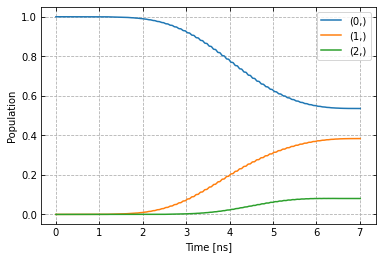

In [114]:
plot_dynamics(exp, init_state, barely_a_seq)

In [115]:
barely_a_seq * 10

['rx90p[0]',
 'rx90p[0]',
 'rx90p[0]',
 'rx90p[0]',
 'rx90p[0]',
 'rx90p[0]',
 'rx90p[0]',
 'rx90p[0]',
 'rx90p[0]',
 'rx90p[0]']

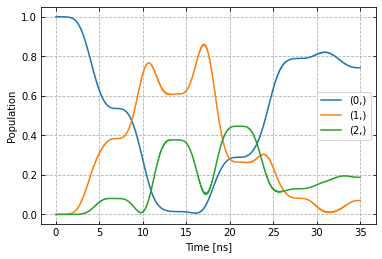

In [116]:
plot_dynamics(exp, init_state, barely_a_seq * 5)

## First order correction
The original envelope has the shape $\Omega_0(t) = \frac{1}{2}(1-\cos(2\pi t / t_f))$, meaning its derivative is $$\dot\Omega_0(t) =- \frac{\pi}{t_f}\sin(2\pi t / t_f)$$

In [117]:
first_order = {
    'amp': Qty(
        value=-0.15,
        min_val=-0.6,
        max_val=0.6,
        unit="V"
    ),
    't_final': Qty(
        value=t_final,
        min_val=0.5 * t_final,
        max_val=1.5 * t_final,
        unit="s"
    ),
    'xy_angle': Qty(
        value=0.5,
        min_val=-0.5,
        max_val=2.5,
        unit='pi'
    ),
    'freq_offset': Qty(
        value=0,
        min_val=-200 * 1e6 ,
        max_val=200 * 1e6 ,
        unit='Hz 2pi'
    )
}
sin = pulse.Envelope(
    name="sin",
    desc="Gaussian comp for single-qubit gates",
    params=first_order,
    shape=envelopes.sine
)
rx90p_fo = gates.Instruction(
    name="rx90p", targets=[0], t_start=0.0, t_end=t_final, channels=["d1"]
)
rx90p_fo.add_component(cos, "d1")
rx90p_fo.add_component(sin, "d1")
rx90p_fo.add_component(carr, "d1")

In [118]:
pmap = PMap(instructions=[rx90p_fo], model=model, generator=generator)
exp = Exp(pmap)

In [119]:
exp.set_opt_gates(["rx90p[0]"])

In [120]:
exp.compute_propagators()

{'rx90p[0]': <tf.Tensor: shape=(3, 3), dtype=complex128, numpy=
 array([[ 0.69047068+0.01974953j, -0.3383201 -0.56105827j,
         -0.12202838-0.28057511j],
        [ 0.1537348 -0.62307997j,  0.42618448-0.34732814j,
          0.41807789+0.33328336j],
        [ 0.29244026-0.15961157j,  0.14424254+0.49767175j,
          0.44121706-0.65256974j]])>}

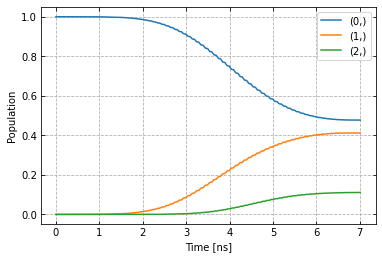

In [121]:
plot_dynamics(exp, init_state, barely_a_seq)

In [122]:
import os
import tempfile
from c3.optimizers.optimalcontrol import OptimalControl

# Create a temporary directory to store logfiles, modify as needed
log_dir = os.path.join(tempfile.TemporaryDirectory().name, "c3logs")

opt = OptimalControl(
    dir_path=log_dir,
    fid_func=fidelities.unitary_infid_set,
    fid_subspace=["Q1"],
    pmap=pmap,
    algorithm=algorithms.lbfgs,
    options={"maxfun" : 150},
    run_name="drag"
)

In [123]:
opt.set_exp(exp)

In [124]:
opt_gates = ["rx90p[0]"]
gateset_opt_map=[
    # [
    #   ("rx90p[0]", "d1", "cos", "amp"),
    # ],
    [
      ("rx90p[0]", "d1", "sin", "amp"),
    ],
    [
      ("rx90p[0]", "d1", "carrier", "framechange"),
    ]
]
pmap.set_opt_map(gateset_opt_map)

In [125]:
opt.run()

C3:STATUS:Saving as: /tmp/tmputnvkbsx/c3logs/drag/2022_02_09_T_18_21_45/open_loop.c3log


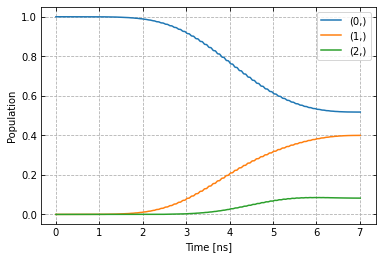

In [126]:
plot_dynamics(exp, init_state, barely_a_seq)

In [127]:
pmap.print_parameters()

rx90p[0]-d1-sin-amp                   : 81.633 mV 
rx90p[0]-d1-carrier-framechange       : 522.388 mrad 



In [128]:
amp_1 = pmap.get_parameter(("rx90p[0]", "d1", "cos", "amp")).numpy()
amp_2 = pmap.get_parameter(("rx90p[0]", "d1", "sin", "amp")).numpy()

In [129]:
amp_2

0.08163321378440869

In [142]:
drag = {
    'amp': Qty(
        value=amp,
        min_val=-0.6,
        max_val=0.6,
        unit="V"
    ),
    "delta": Qty(
        value=-1e-9,
        min_val=-1e-8,
        max_val=1e-8,
        unit=""
    ),
    't_final': Qty(
        value=t_final,
        min_val=0.5 * t_final,
        max_val=1.5 * t_final,
        unit="s"
    ),
    'xy_angle': Qty(
        value=0.0,
        min_val=-0.5,
        max_val=2.5,
        unit='pi'
    ),
    'freq_offset': Qty(
        value=0,
        min_val=-200 * 1e6 ,
        max_val=200 * 1e6 ,
        unit='Hz 2pi'
    )
}
dra = pulse.Envelope(
    name="drag",
    desc="Gaussian comp for single-qubit gates",
    params=drag,
    shape=envelopes.cosine
)
rx90p_drag = gates.Instruction(
    name="rx90p", targets=[0], t_start=0.0, t_end=t_final, channels=["d1"]
)
rx90p_drag.add_component(dra, "d1")
rx90p_drag.add_component(carr, "d1")

In [143]:
awg.enable_drag()

In [144]:
pmap = PMap(instructions=[rx90p_drag], model=model, generator=generator)
exp = Exp(pmap)
exp.set_opt_gates(["rx90p[0]"])
# Create a temporary directory to store logfiles, modify as needed
log_dir = os.path.join(tempfile.TemporaryDirectory().name, "c3logs")

opt = OptimalControl(
    dir_path=log_dir,
    fid_func=fidelities.unitary_infid_set,
    fid_subspace=["Q1"],
    pmap=pmap,
    algorithm=algorithms.lbfgs,
    options={"maxfun" : 150},
    run_name="drag"
)
opt.set_exp(exp)
gateset_opt_map=[
    [
      ("rx90p[0]", "d1", "drag", "amp"),
    ],
    [
      ("rx90p[0]", "d1", "drag", "delta"),
    ],
    [
      ("rx90p[0]", "d1", "drag", "xy_angle"),
    ],
    [
      ("rx90p[0]", "d1", "carrier", "framechange"),
    ]
]
pmap.set_opt_map(gateset_opt_map)
opt.run()
pmap.print_parameters()

C3:STATUS:Saving as: /tmp/tmpa_xp3cyh/c3logs/drag/2022_02_09_T_18_24_56/open_loop.c3log
rx90p[0]-d1-drag-amp                  : 477.229 mV 
rx90p[0]-d1-drag-delta                : -1.301 n 
rx90p[0]-d1-drag-xy_angle             : -77.857 mpi 
rx90p[0]-d1-carrier-framechange       : -489.214 mrad 



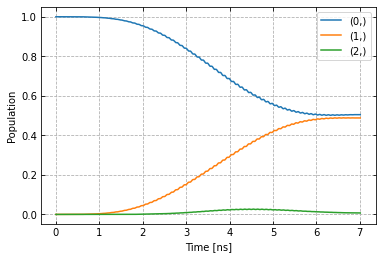

In [145]:
plot_dynamics(exp, init_state, barely_a_seq)

The amplitude of the second envelope is $B=A\frac{\pi}{t_f\Delta}$ or $$\Delta = A\frac{\pi}{t_f B}$$

In [146]:
amp_1/amp_2 * np.pi / t_final / 2e6

1233.6920760792418

In [147]:
signal = generator.generate_signals(rx90p_drag)
vals = signal["d1"]["values"].numpy()
ts =signal["d1"]["ts"].numpy()

In [166]:
plt.plot(ts, vals)

In [172]:
def plot_spectrum(signal):
    signal = generator.generate_signals(rx90p_drag)
    vals = signal["d1"]["values"].numpy()
    ts =signal["d1"]["ts"].numpy()
    spectrum = np.fft.fft(np.append(vals, np.zeros(int(1e5))))
    freq = np.fft.fftfreq(len(spectrum), ts[1])
    inds = np.argsort(freq)
    plt.plot(freq[inds], np.abs(spectrum[inds]))
    plt.xlim(0, 5e9)

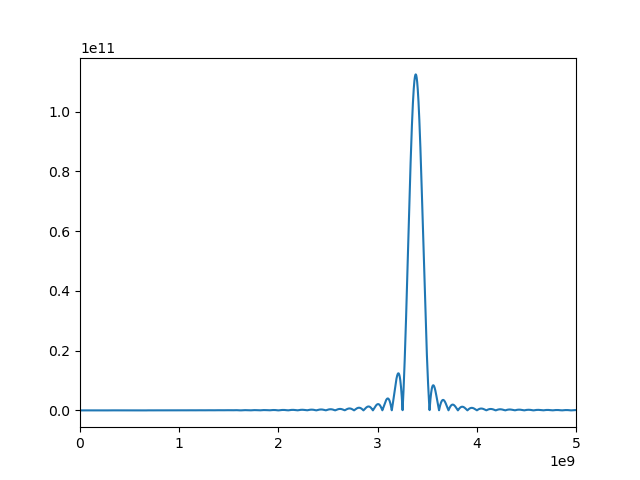

In [173]:
%matplotlib widget
plot_spectrum(generator.generate_signals(rx90p_drag))

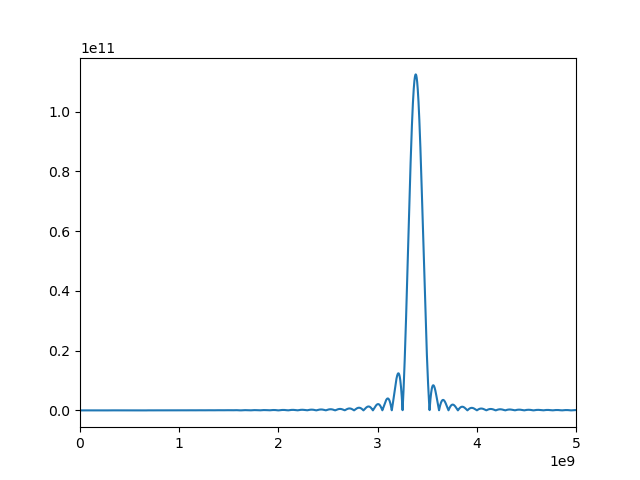

In [174]:
%matplotlib widget
plot_spectrum(generator.generate_signals(rx90p_q1))

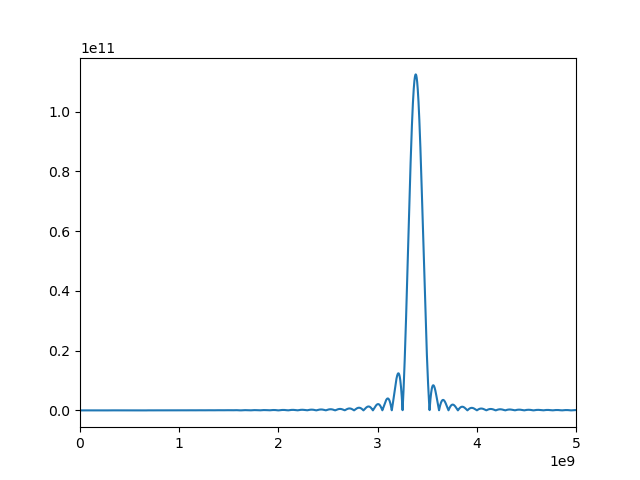

In [175]:
%matplotlib widget
plot_spectrum(generator.generate_signals(rx90p_fo))

In [176]:
rx90p_q1.comps

{'d1': {'cos': cos:: amp : 448.799 mV , delta : 0.000 V , freq_offset : 0.000 Hz 2pi , xy_angle : -444.089 arad , sigma : 5.000 ns , t_final : 7.000 ns , shape: cosine, drag pulseFalse, ,
  'carrier': carrier:: freq : 5.000 GHz 2pi , framechange : -489.214 mrad , }}

In [177]:
3.383/5

0.677